# Potato Disease Classification

Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

### Import all the Dependencies

In [7]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Set all the Constants

In [8]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

### Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [9]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


**Watch below video on tensorflow input pipeline first if you don't know about tensorflow datasets**

In [99]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [11]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

### Visualize some of the images from our dataset

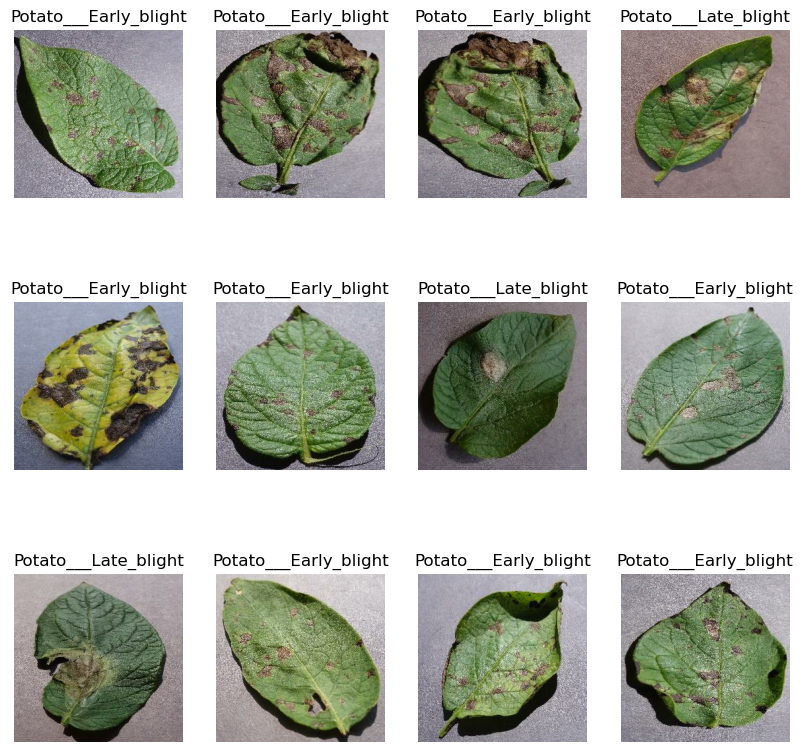

In [12]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [13]:
len(dataset)

68

In [14]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [15]:
train_ds = dataset.take(54)
len(train_ds)

54

In [16]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [17]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [18]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [19]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [20]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [21]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [22]:
len(train_ds)

54

In [23]:
len(val_ds)

6

In [24]:
len(test_ds)

8

### Cache, Shuffle, and Prefetch the Dataset

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [26]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [27]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [28]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



In [29]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
54/54 [==============================] - 75s 1s/step - loss: 0.8385 - accuracy: 0.5880 - val_loss: 0.6800 - val_accuracy: 0.7240
Epoch 2/20
54/54 [==============================] - 69s 1s/step - loss: 0.5521 - accuracy: 0.7801 - val_loss: 0.6221 - val_accuracy: 0.7292
Epoch 3/20
54/54 [==============================] - 68s 1s/step - loss: 0.3858 - accuracy: 0.8356 - val_loss: 0.3327 - val_accuracy: 0.8385
Epoch 4/20
54/54 [==============================] - 68s 1s/step - loss: 0.3245 - accuracy: 0.8814 - val_loss: 0.2877 - val_accuracy: 0.8958
Epoch 5/20
54/54 [==============================] - 67s 1s/step - loss: 0.2651 - accuracy: 0.8935 - val_loss: 0.3731 - val_accuracy: 0.8490
Epoch 6/20
54/54 [==============================] - 67s 1s/step - loss: 0.3034 - accuracy: 0.8877 - val_loss: 0.1897 - val_accuracy: 0.9219
Epoch 7/20
54/54 [==============================] - 67s 1s/step - loss: 0.1881 - accuracy: 0.9167 - val_loss: 0.3415 - val_accuracy: 0.8542
Epoch 8/20
54/54 [==

In [33]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 378ms/step - loss: 0.2945 - accuracy: 0.9258


**You can see above that we get 100.00% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [34]:
scores

[0.29448390007019043, 0.92578125]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [35]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [36]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [37]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [38]:
type(history.history['loss'])

list

In [39]:
len(history.history['loss'])

20

In [40]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.8384807109832764,
 0.5521115660667419,
 0.3857842981815338,
 0.3245055675506592,
 0.26506665349006653]

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

ValueError: x and y must have same first dimension, but have shapes (50,) and (20,)

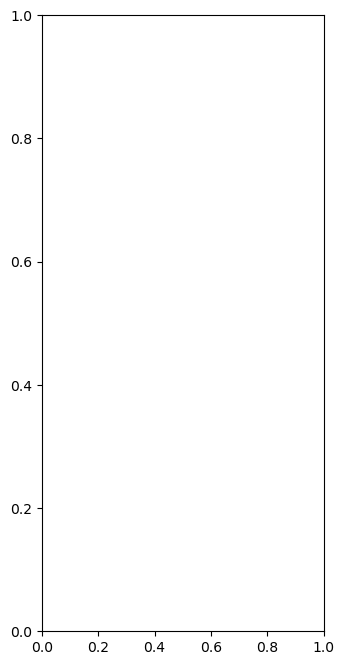

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 462ms/step
predicted label: Potato___Early_blight


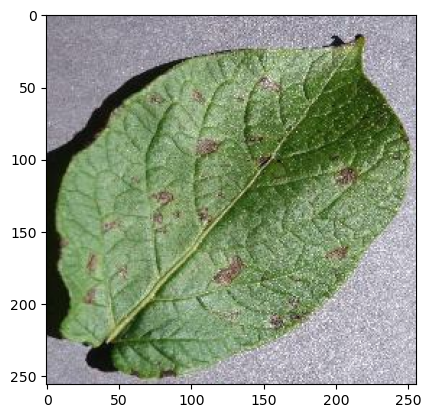

In [43]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [44]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 39ms/step


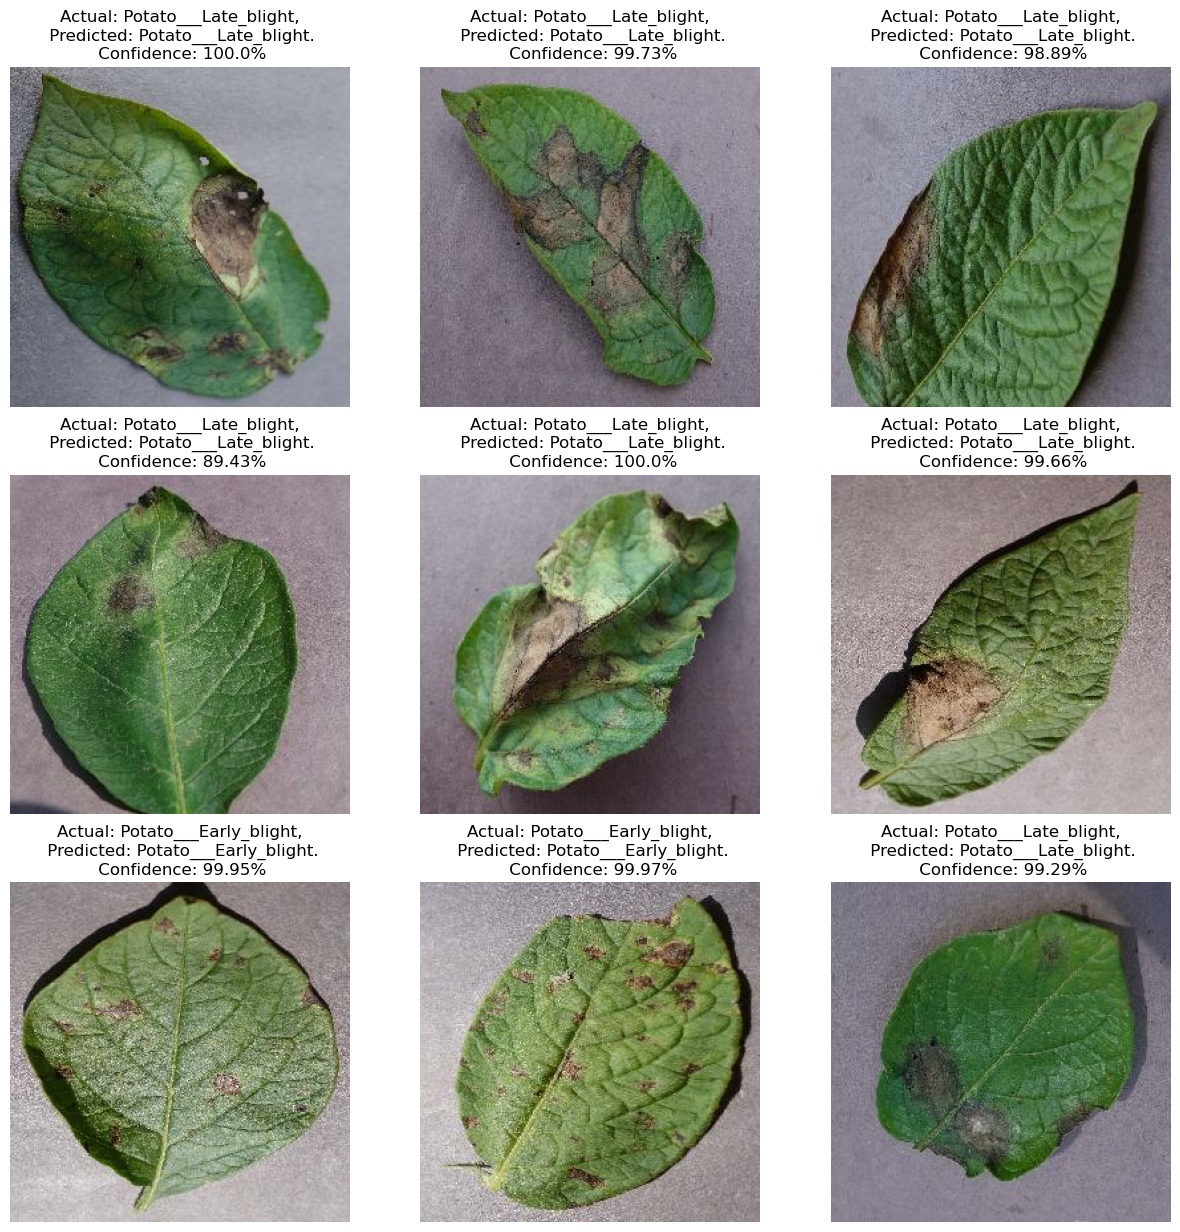

In [45]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [46]:
model.save("potatoes.h5")

C:\Users\okash\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [47]:
model.save("potatoes.keras")

1/1 [==============================] - 0s 15ms/step
Saved 8 images to C:\Users\okash\Downloads\Project\test_ds


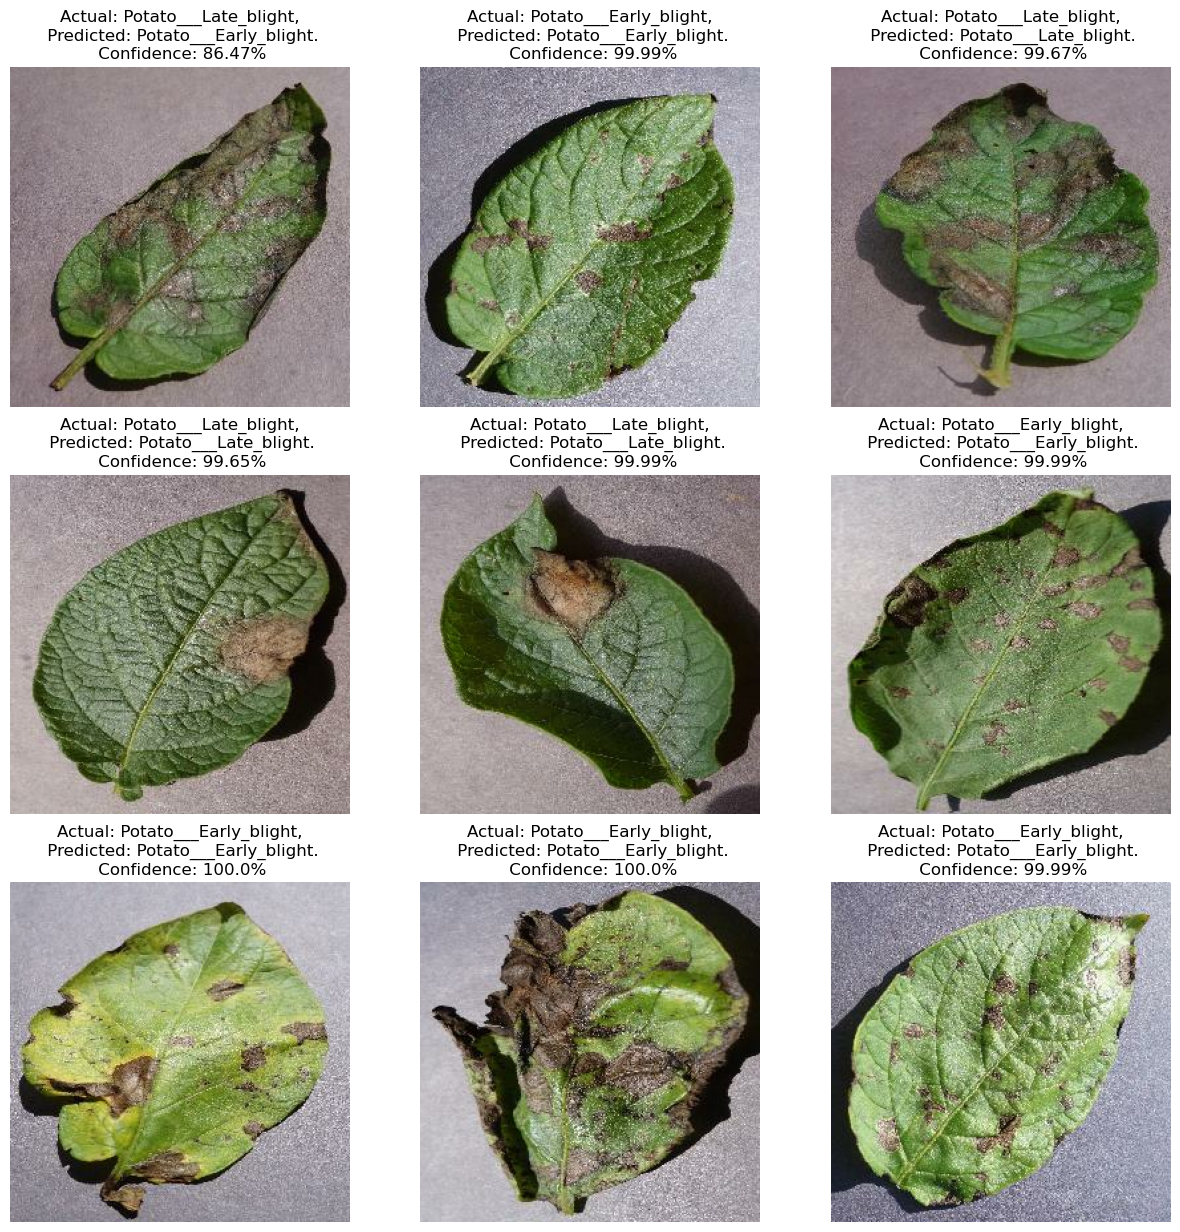

In [105]:
from tensorflow import keras
model1 = keras.models.load_model('potatoes.h5')
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model1, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
        
        
        
import numpy as np
import tensorflow as tf
import os
import cv2

# Define the folder where you want to save the files
output_folder = r'C:\Users\okash\Downloads\Project\test_ds'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Iterate through the dataset and save each image as an image file
for i, (image, label) in enumerate(test_ds):
    # Ensure that the image has the correct shape (256x256) and data type (float32)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, [256, 256])

    # Convert the TensorFlow image tensor to a NumPy array
    image_array = image.numpy()

    # Scale the values to [0, 255]
    image_array = (image_array * 255).astype(np.uint8)

    # Create a file path and file name (you can customize this)
    file_name = f'image_{i}.jpg'
    file_path = os.path.join(output_folder, file_name)

    # Save the image using OpenCV (cv2)
    cv2.imwrite(file_path, cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR))

print(f'Saved {i+1} images to {output_folder}')


In [115]:
from PIL import Image
import numpy as np

# Load and preprocess an image
img = Image.open(r'C:\Users\okash\Downloads\Project\test_ds\img.jpg')
img = img.resize((256, 256))  # Resize the image to match the model's input size
img_array = np.array(img) / 255.0   # Normalize the pixel values (if needed)
img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension
predicted_class, confidence = predict(model1, img_array)
predicted_class = class_names[np.argmax(predictions)]
print(f'Predicted Class: {predicted_class}')

1/1 [==============================] - 0s 33ms/step
Predicted Class: Potato___Late_blight


In [92]:
import numpy as np
import tensorflow as tf
import os
import cv2

# Define the folder where you want to save the files
output_folder = r'C:\Users\okash\Downloads\Project\test_ds'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Iterate through the dataset and save each image as an image file
for i, (image, label) in enumerate(test_ds):
    # Ensure that the image has the correct shape (256x256) and data type (float32)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, [256, 256])

    # Convert the TensorFlow image tensor to a NumPy array
    image_array = image.numpy()

    # Scale the values to [0, 255]
    image_array = (image_array * 255).astype(np.uint8)

    # Create a file path and file name (you can customize this)
    file_name = f'image_{i}.jpg'
    file_path = os.path.join(output_folder, file_name)

    # Save the image using OpenCV (cv2)
    cv2.imwrite(file_path, cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR))

print(f'Saved {i+1} images to {output_folder}')


Saved 8 images to C:\Users\okash\Downloads\Project\test_ds


In [82]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.
